<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9Cch4_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 p.229~240

##**PART 04 합성곱 신경망(CNN)**

###**07 이미지 분할(Segmentation)**

* 이미지 분할(세그멘테이션): 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
  * 즉 모든 픽셀은 어떤 클래스에 속함
  * ex. 배경 클래스와 객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 배경 또는 객체 중 하나로 분류됨
  * 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고, 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있음
  

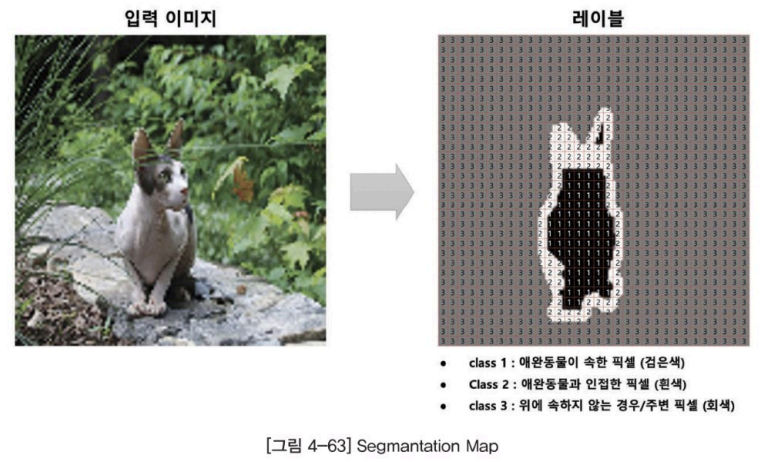

* 이미지 분할은 의미 분할(semantic segmentation)과 인스턴스 분할(instance segmentation)로 구분됨
  * 의미 분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분하는 개념
  * 인스턴스 분할: 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념

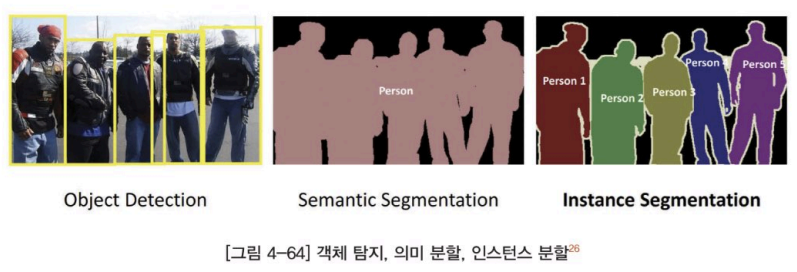

####**7-1 데이터셋 준비**

* Oxford-IIIT Pet Dataset 데이터셋: 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성(여기서 말하는 마스크는 각 픽셀에 대한 범주 레이블을 나타냄)
  * class 1: 반려동물이 속한 픽셀(다음 그림의 노란색 영역)
  * class 2: 반려동물과 인접한 픽셀(빨간색 영역)
  * class 3: 위에 속하지 않는 경우/주변 픽셀(파란색 영역)

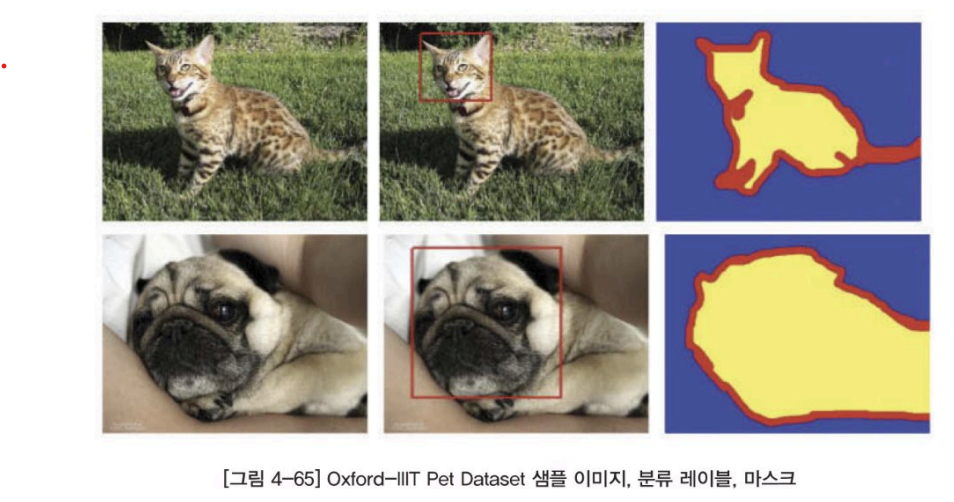

In [ ]:
# 영상 처리를 위한 OpenCV를 비롯한 필수 라이브러리 불러오기

import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [ ]:
# 모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터 설정(주요 파라미터 따로 정리하면 모델의 세부 튜닝 작업을 효율적으로 할 수 있음)

# 이미지 크기
img_w=128
img_h=128
img_c=3
img_shape=(img_w, img_h, img_c)

# 모델 학습
epoch_num=5
learning_rate=0.0001
buffer_size=1000
batch_size=16

In [ ]:
# 텐서플로 데이터셋 로드, 메타 정보 가져와 info 변수에 저장
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6TPK8X/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6TPK8X/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# 원본 이미지와 분할 마스크를 전처리하는 함수 정의
# 원본 이미지의 픽셀을 255로 나눠 0~1 범위로 정규화, 마스크는 0, 1, 2의 정수형 값을 갖도록 1 차감
# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'], (img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

In [ ]:
# 앞에서 정의한 전처리 함수를 훈련 셋, 테스트 셋에 매핑해 주고 미니배치로 분할
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [ ]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

→ 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어있음

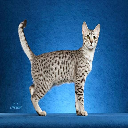

In [ ]:
# 샘플 이미지 출력
# 0~1 사이의 값이므로 255를 곱해 정규화 이전의 원래 값으로 복원
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

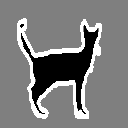

In [ ]:
# 샘플 마스크 출력
# 마스크 값의 범위는 0~2이므로 2로 나눈 다음에 255를 곱하면 RGB 이미지로 표현 가능
mask = (np.array(mask[0]/2)) * 255.0
cv2_imshow(mask)

####**7-2 U-Net 모델(인코더-디코더)**





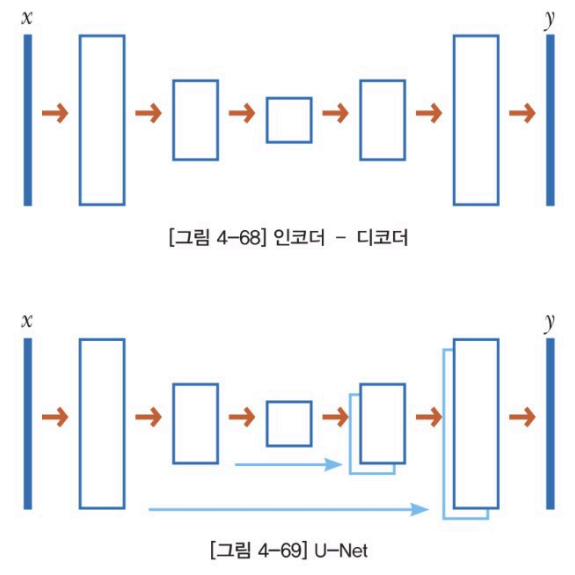

* 사전 학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델(VGG16은 이미지넷 경진 대회를 통해 성능이 검증된 모델)

In [ ]:
# VGG16 모델을 최종 레이어를 제외한 채로 불러오기
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


* VGG16 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조를 가짐

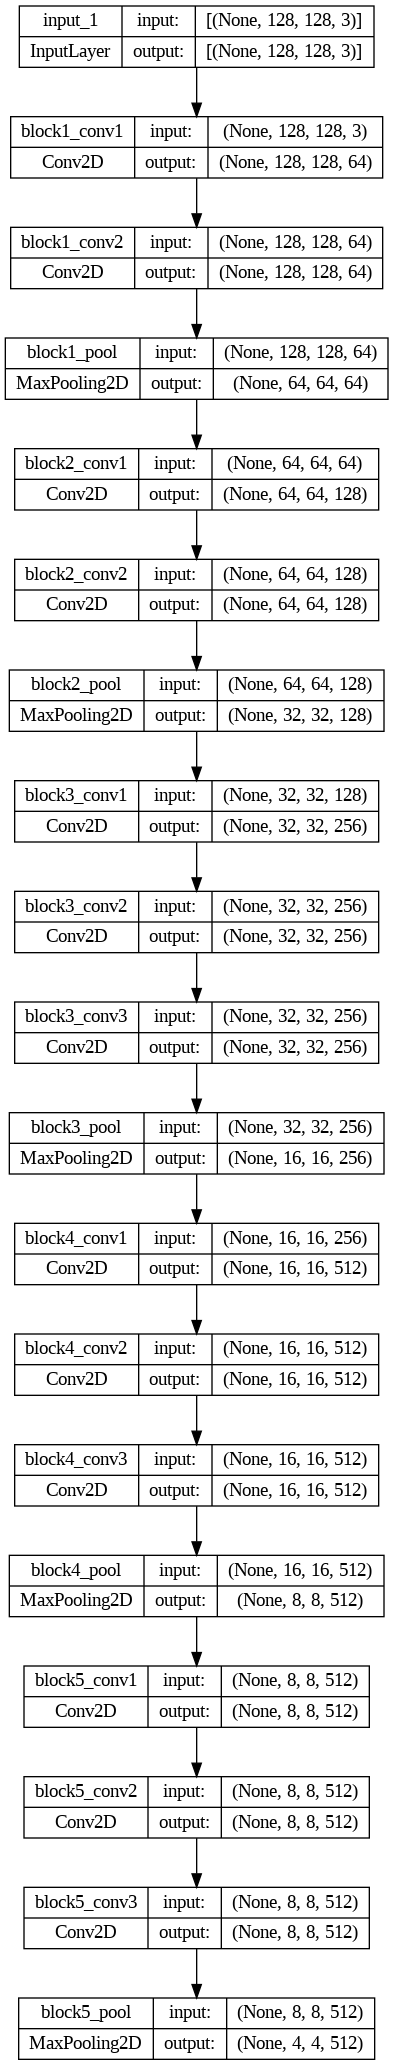

In [ ]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

→ (128, 128) 크기의 텐서가 마지막 레이어에서는 (4, 4) 크기로 축소

→ 이 모델을 U-Net의 인코더로 사용할 예정



* 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소함
* 다시 말하면, 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0, 1, 2 중에서 하나로 분류하는 역할을 함
* 만들고자 하는 U-net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정함
* VGG16모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처(특징)를 추출하는 인코더 모델을 정의하게 됨(여기서는 VGG16 모델로부터 5개의 출력을 가져와서 사용)

In [ ]:
# VGG16 중간 레이어 출력 텐서를 지정
# 새로운 Feature Extractor 모델 정의하고, f_model 변수에 저장, 1개의 입력과 5개의 출력을 가짐
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output
                         ])

In [ ]:
# 파라미터 고정(사전 학습된 파라미터를 인코더에 그대로 사용하기 위해서 업데이트되지 않도록)
f_model.trainable = False

* 업샘플링: 축소된 이미지를 원래 이미지 크기로 복원하는 과정

In [ ]:
# 인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링(Up-Sampling)함
# 제일 작은 (8, 8, 512) 텐서에서 시작해서 조금씩 크기를 키워 나가며 중간 출력과 합침
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64=f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

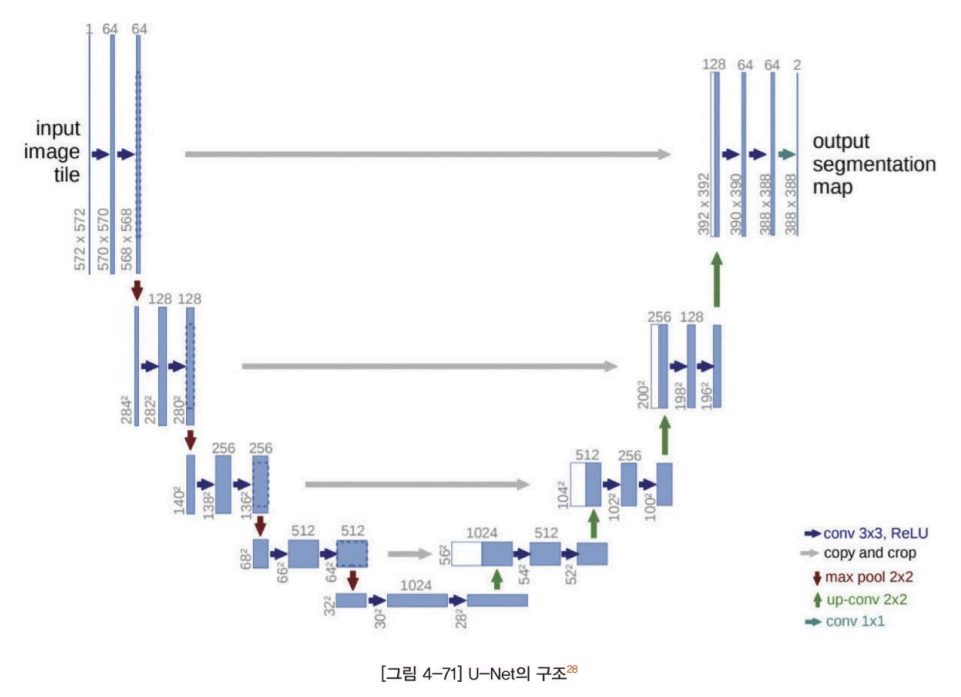

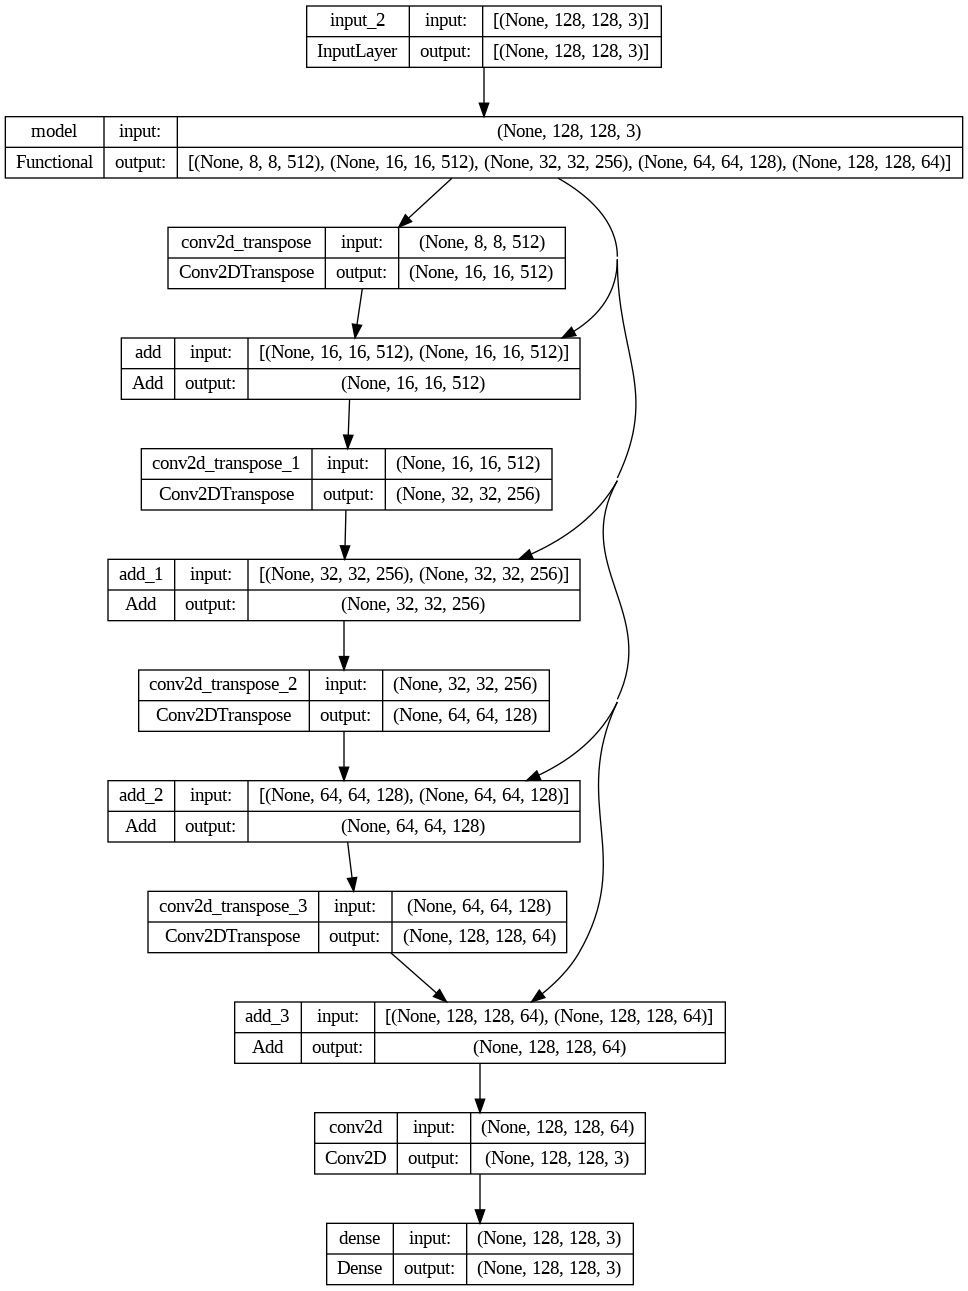

In [ ]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

→ 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐짐

In [ ]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

→ 인코더 출력에 사용하기 위해 f_model로부터 유래하는 5개 레이어의 14,714,688개의 파라미터는 학습되지 않도록 고정되어 있음

In [ ]:
# 예측 클래스 개수가 3개인 다중 분류 문제에 맞도록 SparseCategoricalCrossentropy 손실함수 설정, Adam 옵티마이저 적용
# 기본 성능을 확인하는 수준에서 5 epoch만 훈련
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 913s 4s/step - loss: 0.7035 - accuracy: 0.7251
Epoch 2/5
230/230 [==============================] - 920s 4s/step - loss: 0.4689 - accuracy: 0.8039
Epoch 3/5
230/230 [==============================] - 914s 4s/step - loss: 0.4359 - accuracy: 0.8139
Epoch 4/5
230/230 [==============================] - 916s 4s/step - loss: 0.4192 - accuracy: 0.8190
Epoch 5/5
230/230 [==============================] - 910s 4s/step - loss: 0.4070 - accuracy: 0.8241


1/1 [==============================] - 4s 4s/step


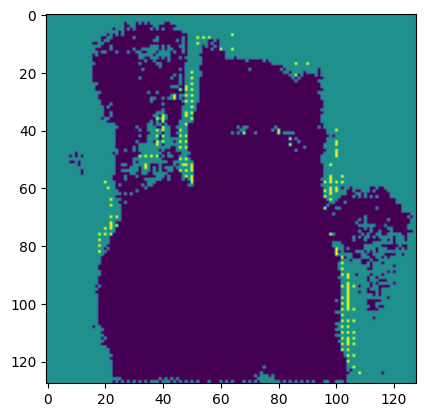

In [ ]:
# 검증 셋의 배치를 하나 선택하고 predict() 메소드로 이미지 분할 클래스 예측
# 배치를 구성하는 16개의 이미지 중에서 첫 번째 이미지의 분할 결과 출력
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

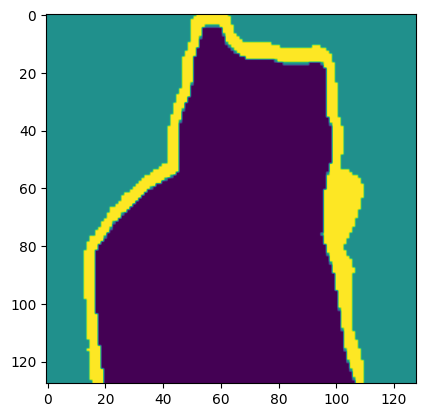

In [ ]:
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128, 128)))

→ 어느 정도 객체의 경계를 찾아냄